# Prepare dataframe

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt

import graph_helpers as gh
import stats_helpers as sh

OUTDATED_IGNORE=1 # skip warning message about package updates

# datapaths
basepath = '/rds/general/project/adobe_addiction_and_obesity_cohort/live/output/structural_covariance/'
freesurferpath = '/rds/general/project/adobe_addiction_and_obesity_cohort/live/output/freesurfer/'
labelfile='/rds/general/user/lfonvill/home/ICCAM_CLEANED_v5_040619.csv'

# build the base dataframe from data in the selected folder
outputdir = os.path.join(basepath, 'HC_ALC_n126', 'DKT_cortVol_subVol_ols_robust')
if not os.path.exists(outputdir):
    os.makedirs(outputdir)
#df, coords = gh.buildDF(outputdir,atlas='DKT', fspath=freesurferpath, labelfile=labelfile, measure='volume', subcortical=True, grouping='alc',method='ols')
df, coords = gh.buildDF(outputdir,atlas='DKT', measure='volume', subcortical=True, grouping='alc',method='ols')
df.head()

,ID,group,site,lh_middletemporal_volume,lh_bankssts_volume,lh_superiortemporal_volume,lh_supramarginal_volume,lh_inferiortemporal_volume,lh_parsopercularis_volume,lh_transversetemporal_volume,...,rh_posteriorcingulate_volume,rh_rostralanteriorcingulate_volume,rh_caudalanteriorcingulate_volume,Right-Thalamus-Proper,Right-Caudate,Right-Putamen,Right-Pallidum,Right-Hippocampus,Right-Amygdala,Right-Accumbens-area
0,sub-1002,1,1.0,872.743305,74.614112,746.455493,115.605689,-905.078810,-37.438614,-17.059753,...,-1269.403966,-409.113825,-304.213898,-803.184153,-509.400113,-747.745213,-62.555354,-775.360565,-170.815299,-226.345809
1,sub-1003,1,1.0,-629.442025,13.796343,-292.016023,21.185568,1083.828234,52.646062,34.601371,...,-22.100107,-565.019824,-399.635875,-671.737526,395.859764,279.735153,-19.191128,50.479279,-214.599840,103.601650
2,sub-1004,1,1.0,-4.912847,265.608535,1439.709503,1722.197716,-1853.400714,485.862318,169.448844,...,90.941928,65.776173,-390.374173,-401.070906,-227.933750,-199.391427,1.965736,-32.118303,-238.375926,-38.655111
3,sub-1005,0,1.0,2658.536334,1106.822349,2475.425296,1975.602046,1271.598310,312.872146,-26.446153,...,1085.306151,225.085440,-210.365756,-248.601672,81.892378,1044.792543,216.996515,296.648698,240.648561,81.179379
4,sub-1007,0,1.0,1245.009931,645.555860,1207.816021,-1559.612889,-678.274554,-233.999491,-1.916482,...,-351.194206,-510.184178,-662.657885,428.684870,-407.542682,123.131867,-193.593878,-116.768491,-135.796264,-39.838367


# Plot input data

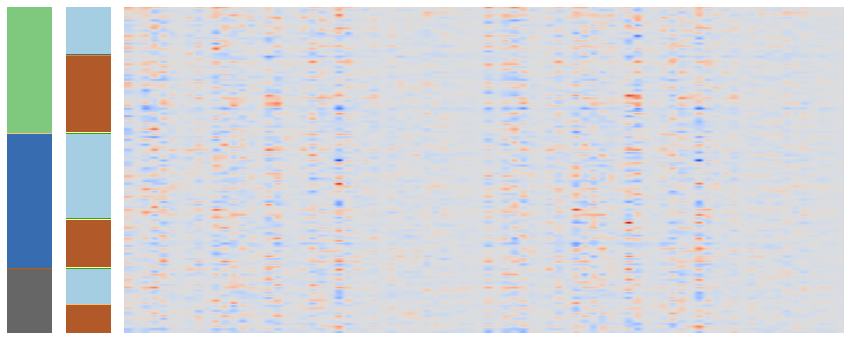

In [3]:
%matplotlib inline
from matplotlib import gridspec
plotdf = df.sort_values(['site', 'group'])
plotdf_aparc = plotdf.filter(regex='lh|Left|rh|Right', axis=1).to_numpy()
fig, axs = plt.subplots(1, 3, figsize=(15, 6));
gs = gridspec.GridSpec(1, 3, width_ratios=[0.5, 0.5, 8], wspace=0.05); 
axs[0] = plt.subplot(gs[0]);
axs[0].imshow(plotdf.loc[:, ['site']].to_numpy(), aspect='auto', cmap='Accent');
axs[0].axis('off');
axs[1] = plt.subplot(gs[1]);
axs[1].imshow(plotdf.loc[:, ['group']].to_numpy(), aspect='auto', cmap='Paired');
axs[1].axis('off');
axs[2] = plt.subplot(gs[2]);
axs[2].imshow(plotdf_aparc, aspect='auto', cmap='coolwarm');
axs[2].axis('off');

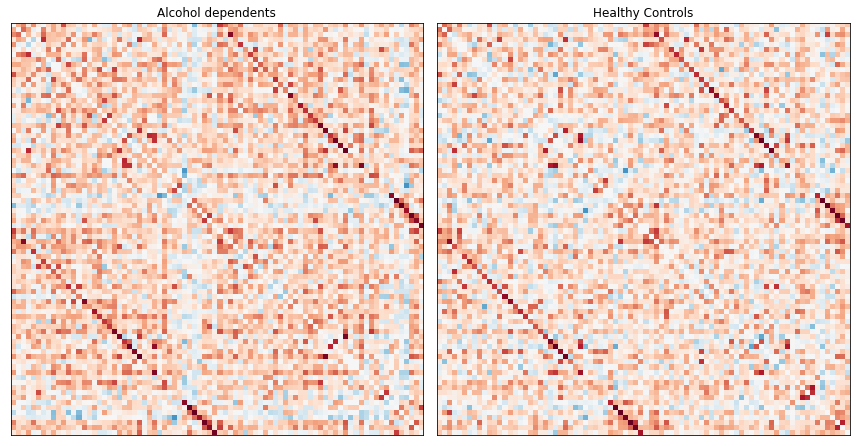

In [4]:
%matplotlib inline
M0, M1 = gh.robustMat(outputdir, df, overwrite=False)
fig, axes = plt.subplots(1,2, figsize=(12, 8))
[ax.get_xaxis().set_ticks([]) for ax in axes.ravel()]
[ax.get_yaxis().set_ticks([]) for ax in axes.ravel()]
axes[0].imshow(M1, vmin=-0.8, vmax=0.8, cmap='RdBu_r');
axes[0].set_title('Alcohol dependents', fontsize=12);
axes[1].imshow(M0, vmin=-0.8, vmax=0.8, cmap='RdBu_r');
axes[1].set_title('Healthy Controls', fontsize=12);
plt.tight_layout()
plt.show()

# Global group differences

In [5]:
permdir = os.path.join(outputdir, 'permutations')
global_permdf, local_permdf = sh.getPermutationsFast(permdir, overwrite=False)
global_df = pd.read_csv(outputdir + '/global/global_differences.csv', index_col=0)
global_testdf = None
global_nulldf, global_critdf = sh.getCrit(global_df, global_permdf, 'global')
global_testdf = sh.thresholdDF(global_df, global_critdf, level='global', maxThr=40)
if global_testdf is not None:
    # calculate p-value and check AUC
    global_testdf = sh.calcP(global_testdf, global_nulldf, level='global', nPermutations=2000)
    global_aucdf = sh.calcAUC(global_testdf, global_df, global_permdf, level='global', maxThr=40, nInterp=500, nPerms=2000)
    global_aucdf.to_csv(outputdir + '/global/global_AUC_thr40.csv')
global_critdf.to_csv(outputdir + '/global/global_critdf.csv')   
global_aucdf.head(n=20)

,name,threshold,metric,obsVal,critVal,pVal,obsAUC,critAUC
0,global,5,modularity,0.126397,0.087441,0.0040,0.083956,0.001419
1,global,6,modularity,0.089783,0.087441,0.0475,0.083956,0.001419
2,global,8,modularity,0.099850,0.087441,0.0240,0.083956,0.001419
3,global,9,modularity,0.093562,0.087441,0.0350,0.083956,0.001419
4,global,11,modularity,0.101137,0.087441,0.0220,0.083956,0.001419
5,global,12,modularity,0.104004,0.087441,0.0185,0.083956,0.001419
6,global,14,modularity,0.103244,0.087441,0.0200,0.083956,0.001419
7,global,15,modularity,0.095480,0.087441,0.0320,0.083956,0.001419


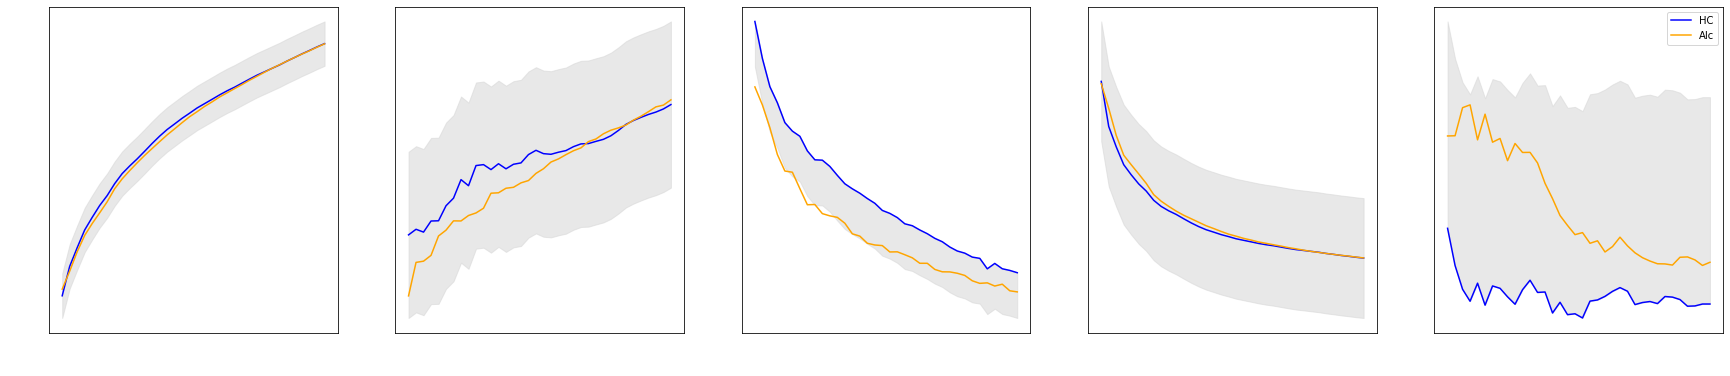

In [6]:
%matplotlib inline
hc_global_df = pd.read_csv(outputdir + '/global/HC_global.csv', index_col=0)
alc_global_df = pd.read_csv(outputdir + '/global/ALC_global.csv', index_col=0)
metrics = ['efficiency', 'average_clustering', 'modularity', 'average_shortest_path_length', 'assortativity']
name = ['Global Efficiency', 'Average Clustering', 'Modularity', 'Shortest Path Length', 'Assortativity']
font = {'color':  'white',
        'weight': 'normal',
        'size': 15,
        }
fig, axes = plt.subplots(1, 5, figsize=(30,6))
x = global_df.threshold
for i, m in enumerate(metrics):
    hc_y = hc_global_df.loc[:, m].values
    alc_y = alc_global_df.loc[:, m].values
    diff = global_critdf.loc[:, m].values
    # plot alc and hc values
    axes[i].plot(x, hc_y, 'b-')
    axes[i].plot(x, alc_y, 'orange')
    axes[i].tick_params(colors='white')
    axes[i].set_xlabel('Threshold (%)', fontdict=font)
    axes[i].set_ylabel(name[i], fontdict=font)
    # add critical difference line 
    if all(global_df.loc[:, m]>0):
        axes[i].fill_between(x, hc_y, hc_y-diff, color='lightgrey', alpha=0.5)
    elif all(global_df.loc[:, m]<0):
        axes[i].fill_between(x, hc_y, hc_y-diff, color='lightgrey', alpha=0.5)
    else:
        axes[i].fill_between(x, hc_y+diff, hc_y-diff, color='lightgrey', alpha=0.5)
plt.legend(["HC", "Alc"], loc='upper right');            